In [1]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 97 kB 6.0 MB/s 
     |████████████████████████████████| 376 kB 65.0 MB/s 
     |████████████████████████████████| 58 kB 7.0 MB/s 
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=3f7e6b00217b63a754a27df9b487b2b7241ebd811b2816030f39307ccf54c9c2
  Stored in directory: /root/.cache/pip/wheels/0e/cc/b2/49e74588263573ff778da58cc99b9c6349b496636a7e165be6
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60966 sha256=383933835c84fd5618cadb58a3120374b3988edb27b4ad8f1577d3636ecfc20a
  Stored in directory: /root/.cache/pip/wheels/ed/27/e8/9543d42de2740d3544db96aefef63bda3f2c1761b3334f4873
Successfully built efficientnet-pytorch pretrainedmodels
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning htt

# Download Full Dataset

Market-1501 dataset :
https://www.kaggle.com/pengcw1/market-1501

In [2]:
!git clone https://github.com/parth1620/Person-Re-Id-Dataset

Cloning into 'Person-Re-Id-Dataset'...
remote: Enumerating objects: 12942, done.
remote: Counting objects: 100% (12942/12942), done.
remote: Compressing objects: 100% (12942/12942), done.
remote: Total 12942 (delta 0), reused 12942 (delta 0), pack-reused 0
Receiving objects: 100% (12942/12942), 27.68 MiB | 6.39 MiB/s, done.


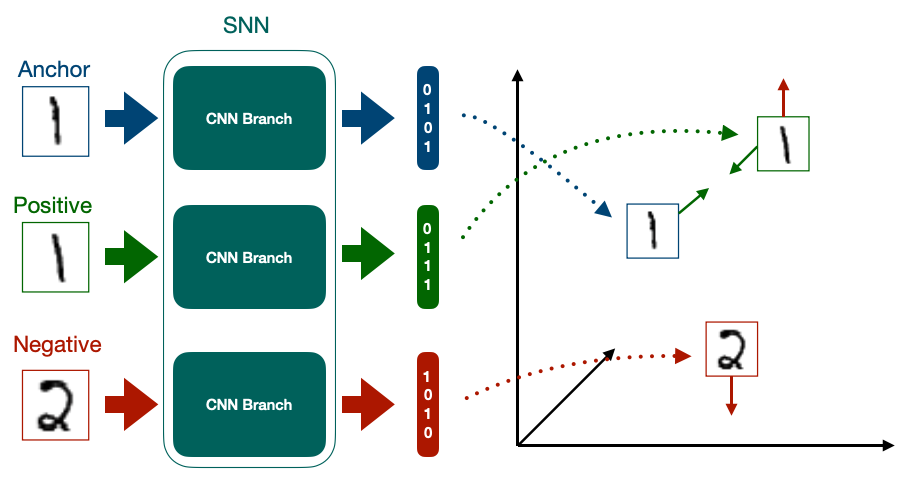

# Imports

In [3]:
import sys 
sys.path.append('/content/Person-Re-Id-Dataset')

In [4]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import torch 
import timm

import torch.nn.functional as F 
from torch import nn 
from torch.utils.data import Dataset, DataLoader 

from skimage import io
from sklearn.model_selection import train_test_split 

from tqdm import tqdm 

# Configurations

In [5]:
Data_Dir = "/content/Person-Re-Id-Dataset/train/"
CSV_File="/content/Person-Re-Id-Dataset/train.csv"
batch_size = 32
lr= 0.001
epochs = 15
device = 'cuda'

In [6]:
df= pd.read_csv(CSV_File)
df.head()


,Anchor,Negative,Positive
0,1420_c5s3_052165_01.jpg,1334_c6s3_061492_05.jpg,1420_c3s3_051678_01.jpg
1,1420_c3s3_061978_03.jpg,0234_c3s3_079494_02.jpg,1420_c6s3_085567_02.jpg
2,1420_c5s3_062565_05.jpg,0475_c2s1_122816_08.jpg,1420_c3s3_051653_01.jpg
3,1420_c6s3_085592_04.jpg,0662_c2s2_036662_05.jpg,1420_c1s6_013446_04.jpg
4,0663_c5s3_085987_03.jpg,1463_c2s3_098102_02.jpg,0663_c3s3_085544_06.jpg


In [7]:
row = df.iloc[10]
A_img = io.imread(Data_Dir + row.Anchor)
P_img = io.imread(Data_Dir + row.Positive)
N_img = io.imread(Data_Dir + row.Negative)

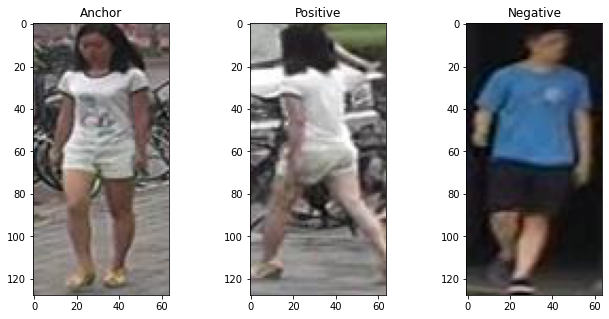

In [8]:
f,(ax1,ax2,ax3)= plt.subplots(1,3,figsize = (11,5))

ax1.set_title("Anchor")
ax1.imshow(A_img)

ax2.set_title("Positive")
ax2.imshow(P_img)

ax3.set_title("Negative")
ax3.imshow(N_img)

In [9]:
train_df,valid_df = train_test_split(df,test_size = 0.20,random_state=42)

# Create APN Dataset 

In [10]:
class APN_Dataset(Dataset):
  def __init__(self,df):
    self.df = df

  def __len__(self):
    return len(self.df)

  def __getitem__(self,idx):
    row = self.df.iloc[idx]
    A_img = io.imread(Data_Dir + row.Anchor)
    P_img = io.imread(Data_Dir + row.Positive)
    N_img = io.imread(Data_Dir + row.Negative)

    A_img = torch.from_numpy(A_img).permute(2,0,1)/255.0
    P_img = torch.from_numpy(P_img).permute(2,0,1)/255.0
    N_img = torch.from_numpy(N_img).permute(2,0,1)/255.0

    return A_img,P_img,N_img



    

In [11]:
trainset = APN_Dataset(train_df)
validset = APN_Dataset(valid_df)
print("size of train_set : {len(train_set)}")
print("size of valid_set :{len(valid_set)}")

size of train_set : {len(train_set)}
size of valid_set :{len(valid_set)}


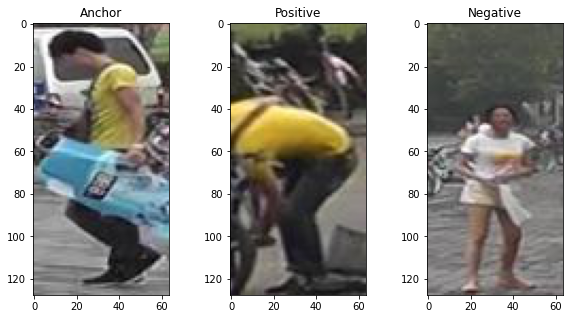

In [12]:
idx = 40
A,P,N = trainset[idx]

f, (ax1, ax2, ax3) = plt.subplots(1,3,figsize= (10,5))

ax1.set_title('Anchor')
ax1.imshow(A.numpy().transpose((1,2,0)), cmap = 'gray')

ax2.set_title('Positive')
ax2.imshow(P.numpy().transpose((1,2,0)), cmap = 'gray')

ax3.set_title('Negative')
ax3.imshow(N.numpy().transpose((1,2,0)), cmap = 'gray')

# Load Dataset into Batches

In [13]:
trainloader = DataLoader(trainset,batch_size=batch_size,shuffle = True)
validloader = DataLoader(validset, batch_size = batch_size)

In [14]:
print(f"No. of batches in trainloader : {len(trainloader)}")
print(f"No. of batches in validloader : {len(validloader)}")

No. of batches in trainloader : 100
No. of batches in validloader : 25


In [15]:
for A,P,N in trainloader:
  break;
    
print(f"One image batch shape : {A.shape}")

One image batch shape : torch.Size([32, 3, 128, 64])


# Create Model 

In [16]:
class APN_Model(nn.Module):

  def __init__(self,emb_size = 512):
    super(APN_Model, self).__init__()

    self.efficientnet = timm.create_model('efficientnet_b0',pretrained = True)
    self.efficientnet.classifier = nn.Linear(in_features = self.efficientnet.classifier.in_features,out_features = emb_size )
  def forward(self, images):
    embeddings = self.efficientnet(images)
    return embeddings

In [17]:
model = APN_Model()
model.to(device)

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/efficientnet_b0_ra-3dd342df.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_ra-3dd342df.pth


APN_Model(
  (efficientnet): EfficientNet(
    (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act1): SiLU(inplace=True)
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (act1): SiLU(inplace=True)
          (se): SqueezeExcite(
            (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (act1): SiLU(inplace=True)
            (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (gate): Sigmoid()
          )
          (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine

# Create Train and Eval function

In [18]:
def train_fn(model,dataloader,optimizer,criterion):
  model.train() # On DropOut
  total_loss= 0.0
  for A,P,N in tqdm(dataloader):

    A,P,N =A.to(device), P.to(device),N.to(device)

    A_embs = model(A)
    P_embs = model(P)
    N_embs = model(N)

    loss = criterion(A_embs,P_embs,N_embs)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    total_loss += loss.item()
  
  return total_loss / len(dataloader)
  

In [19]:
def eval_fn(model,dataloader,criterion):
  model.eval() # OFF DropOut
  total_loss= 0.0
  with torch.no_grad():
    for A,P,N in tqdm(dataloader):

      A,P,N =A.to(device), P.to(device),N.to(device)

      A_embs = model(A)
      P_embs = model(P)
      N_embs = model(N)

      loss = criterion(A_embs,P_embs,N_embs)
      
      total_loss += loss.item()
    
    return total_loss / len(dataloader)
    

In [20]:
criterion = nn.TripletMarginLoss()
optimizer = torch.optim.Adam(model.parameters(),lr = lr)

# Create Training Loop

In [21]:
best_valid_loss = np.Inf

for i in range(epochs):

  train_loss = train_fn(model,trainloader,optimizer,criterion)
  valid_loss = eval_fn(model,validloader,criterion)

  if valid_loss < best_valid_loss:
    torch.save(model.state_dict(), 'best_model.pt')
    best_valid_loss = valid_loss
    print('saved_weights_success')
  
  print(f'epochs : {i+1} train_loss : {train_loss} valid_loss : {valid_loss}')

100%|██████████| 25/25 [00:02<00:00, 10.52it/s]


saved_weights_success
epochs : 1 train_loss : 0.5796140541136264 valid_loss : 0.4111999827623367


100%|██████████| 25/25 [00:02<00:00, 10.70it/s]


saved_weights_success
epochs : 2 train_loss : 0.243524299710989 valid_loss : 0.3236160683631897


100%|██████████| 25/25 [00:02<00:00, 10.97it/s]


epochs : 3 train_loss : 0.21411043718457223 valid_loss : 0.35188830256462095


100%|██████████| 25/25 [00:02<00:00, 10.77it/s]


saved_weights_success
epochs : 4 train_loss : 0.12653220258653164 valid_loss : 0.2222938221693039


100%|██████████| 25/25 [00:02<00:00, 10.74it/s]


saved_weights_success
epochs : 5 train_loss : 0.08082343876361847 valid_loss : 0.20759403795003892


100%|██████████| 25/25 [00:02<00:00, 10.64it/s]


saved_weights_success
epochs : 6 train_loss : 0.058740423023700715 valid_loss : 0.16739599883556366


100%|██████████| 25/25 [00:02<00:00, 10.66it/s]


epochs : 7 train_loss : 0.05677049644291401 valid_loss : 0.1829454356431961


100%|██████████| 25/25 [00:02<00:00, 10.86it/s]


epochs : 8 train_loss : 0.048970659226179124 valid_loss : 0.1774496877193451


100%|██████████| 25/25 [00:02<00:00, 10.90it/s]


saved_weights_success
epochs : 9 train_loss : 0.04645969577133655 valid_loss : 0.14503297626972197


100%|██████████| 25/25 [00:02<00:00, 10.55it/s]


epochs : 10 train_loss : 0.048018025308847426 valid_loss : 0.17227300822734834


100%|██████████| 25/25 [00:02<00:00, 10.63it/s]


epochs : 11 train_loss : 0.05022889465093613 valid_loss : 0.1977662616968155


100%|██████████| 25/25 [00:02<00:00, 10.81it/s]


epochs : 12 train_loss : 0.0643477500230074 valid_loss : 0.24131892681121825


100%|██████████| 25/25 [00:02<00:00, 10.70it/s]


epochs : 13 train_loss : 0.07385154113173485 valid_loss : 0.1833183127641678


100%|██████████| 25/25 [00:02<00:00, 10.53it/s]


epochs : 14 train_loss : 0.03466595686972141 valid_loss : 0.2032062977552414


100%|██████████| 25/25 [00:02<00:00, 10.76it/s]

epochs : 15 train_loss : 0.03188009388744831 valid_loss : 0.17270466774702073


# Get Anchor Embeddings

In [22]:
def get_encoding_csv(model,anc_img_names):
    anc_img_names_arr = np.array(anc_img_names)
    encodings = []

    model.eval()
    with torch.no_grad():
        for i in tqdm(anc_img_names_arr):
            A= io.imread(Data_Dir +i)
            A = torch.from_numpy(A).permute(2,0,1) / 255.0
            A= A.to(device)
            A_enc = model(A.unsqueeze(0)) # (c,h,w) -> (1,c,h,w)
            encodings.append(A_enc.squeeze().cpu().detach().numpy())

        encodings= np.array(encodings)
        encodings = pd.DataFrame(encodings)
        df_enc = pd.concat([anc_img_names,encodings],axis = 1)

    return df_enc


In [23]:
model.load_state_dict(torch.load("best_model.pt"))
df_enc = get_encoding_csv(model,df['Anchor'])

100%|██████████| 4000/4000 [00:41<00:00, 95.81it/s]


In [24]:
df_enc.to_csv('database.csv',index = False)
df_enc.head()

,Anchor,0,1,2,3,4,5,6,7,8,...,502,503,504,505,506,507,508,509,510,511
0,1420_c5s3_052165_01.jpg,0.984029,0.176506,-0.259318,0.122133,-0.151575,-1.397786,0.081494,0.218329,0.493339,...,0.355487,1.341572,1.462205,0.148455,-0.261092,-0.048956,-0.185939,0.635216,0.670101,0.029825
1,1420_c3s3_061978_03.jpg,0.854374,0.490661,0.044557,-0.321386,-0.305310,-1.071669,0.042317,0.070854,0.422598,...,0.305719,1.198452,0.959215,0.202039,-0.009428,-0.116008,-0.012874,0.745541,0.677648,0.084873
2,1420_c5s3_062565_05.jpg,1.210546,0.347279,-0.013893,-0.086966,-0.132976,-1.016078,0.057477,0.052664,0.425637,...,0.546843,1.551373,1.245439,0.545673,-0.015561,-0.151530,-0.088224,0.607418,0.405101,0.122912
3,1420_c6s3_085592_04.jpg,0.886205,0.468651,-0.301123,-0.336196,-0.465585,-0.783030,0.291879,0.251486,0.659511,...,1.027188,1.243304,1.308352,0.336149,-0.292771,0.092070,-0.396230,0.610523,0.358680,0.303666
4,0663_c5s3_085987_03.jpg,-0.599496,-0.684528,-1.897148,0.711461,0.125261,1.306207,0.379705,0.487248,1.455006,...,-0.075393,-0.955478,1.299163,-0.055307,0.222856,0.407856,-1.855320,-0.256849,-0.935863,-0.764894


# Inference

In [30]:
def euclidean_dist(img_enc,anc_enc_arr):
    dist =np.sqrt(np.dot(img_enc - anc_enc_arr,(img_enc - anc_enc_arr).T))
    return dist

In [31]:
idx = 0
img_name = df_enc["Anchor"].iloc[idx]
img_path = Data_Dir +img_name

img = io.imread(img_path)
img = torch.from_numpy(img).permute(2,0,1)/255.0
model.eval()
with torch.no_grad():
    img = img.to(device)
    img_enc = model(img.unsqueeze(0))
    img_enc = img_enc.detach().cpu().numpy()

In [32]:
anc_enc_arr = df_enc.iloc[:,1:].to_numpy()
anc_img_names = df_enc['Anchor']

In [33]:
distance = []

for i in range(anc_enc_arr.shape[0]):
    dist = euclidean_dist(img_enc,anc_enc_arr[i: i+1 ,:])
    distance = np.append(distance,dist)

In [34]:
closest_idx = np.argsort(distance)

/usr/local/lib/python3.7/dist-packages/networkx/drawing/layout.py:727: RuntimeWarning: divide by zero encountered in true_divide
  costargs = (np, 1 / (dist_mtx + np.eye(dist_mtx.shape[0]) * 1e-3), meanwt, dim)


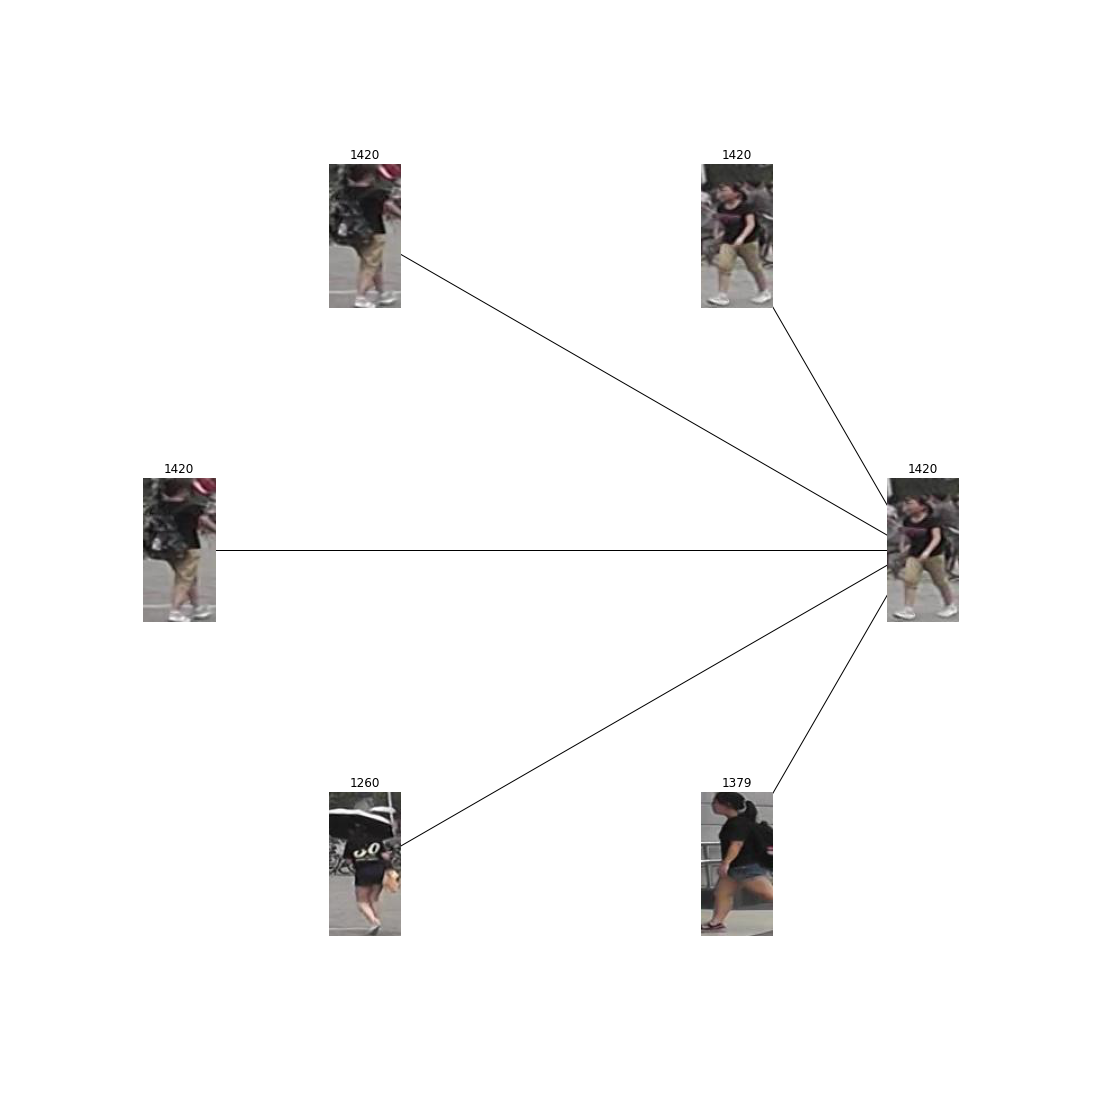

In [35]:
from utils import plot_closest_imgs

plot_closest_imgs(anc_img_names, Data_Dir, img, img_path, closest_idx, distance, no_of_closest = 5);